# GSOWeather

## Objectives:
### Plot any hourly weather condition over time

    


## Task 1:
### Plot Hourly precipitation over time

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Make a dataframe of the columns we need 
GraphingColumns = ['DATE',
'REPORTTPYE',
'HOURLYPrecip',
'HOURLYWindSpeed']
GraphingDF = pd.read_csv(r'../data/1052640.csv',usecols = GraphingColumns, low_memory = False)


In [3]:
# Rename the Report'tpye' column to prevent headaches 
GraphingDF.rename(columns = {'REPORTTPYE':'REPORTTYPE'}, inplace=True)

In [4]:
# Drop StartOfDay values (always NaN)
GraphingDF = GraphingDF[GraphingDF.REPORTTYPE != 'SOD']

In [5]:
# Index based on DATE, then drop DATE
GraphingDF.set_index(GraphingDF['DATE'].apply(pd.to_datetime),inplace=True)
GraphingDF = GraphingDF.drop('DATE',axis=1)

In [6]:

# Graph the hourly precipitation (Finally!)
dateTime = GraphingDF.index.values
HourlyPrecipitation = pd.to_numeric(GraphingDF.loc[:,'HOURLYPrecip'].values,errors='coerce')


Precip_chart = plt.figure(figsize=(16,8))
precip = plt.plot(dateTime, HourlyPrecipitation,label= 'HOURLY Precipitation (inches)')

plt.title(' HOURLY Precipitation in inches')

plt.ylabel('precip')
plt.xlabel('time')
plt.legend(loc=0);

In [7]:
# Graph Wind Speed
#dateTime = GraphingDF.index.values
HourlyWindSpeed = GraphingDF.loc[:,'HOURLYWindSpeed']

Precip_chart = plt.figure(figsize=(16,8))
precip = plt.plot(dateTime, HourlyWindSpeed,label= 'HOURLY Wind Speed (mph)')

plt.title(' HOURLY WindSpeed in mph')

plt.ylabel('mph')
plt.xlabel('time')
plt.legend(loc=0);


# Below this cell is work from before 1st presentation

### Defining variables. hourlyColumns may be altered later, but this is what we are using for now

In [8]:
hourlyColumns = ['DATE',
'REPORTTPYE',
'HOURLYSKYCONDITIONS',
'HOURLYVISIBILITY',
'HOURLYPRSENTWEATHERTYPE',
'HOURLYWETBULBTEMPF',
'HOURLYDRYBULBTEMPF',
'HOURLYDewPointTempF',
'HOURLYRelativeHumidity',
'HOURLYWindSpeed',
'HOURLYWindDirection',
'HOURLYWindGustSpeed',
'HOURLYStationPressure',
'HOURLYPressureTendency',
'HOURLYPressureChange',
'HOURLYSeaLevelPressure',
'HOURLYPrecip',
'HOURLYAltimeterSetting']

In [9]:
#Defining functions - all together so we can see them and know what we have to work with
# without scrolling through entire program

In [10]:
def getAllWeatherData():
    return pd.read_csv(r'../data/1052640.csv',low_memory=False)

In [11]:
def getHourlyWeatherData():
    return pd.read_csv(r'../data/1052640.csv',usecols = hourlyColumns, low_memory = False)


In [12]:
def displayWeatherData(array):
    print array.columns.values

In [13]:
#delaring variables from the functions - don't need to know exactly what is in them to use them
gsoDataAll = getAllWeatherData()
gsoDataHours = getHourlyWeatherData()

In [14]:
#How to use the display method
displayWeatherData(gsoDataAll)
displayWeatherData(gsoDataHours)

['STATION' 'STATION_NAME' 'ELEVATION' 'LATITUDE' 'LONGITUDE' 'DATE'
 'REPORTTPYE' 'HOURLYSKYCONDITIONS' 'HOURLYVISIBILITY'
 'HOURLYPRSENTWEATHERTYPE' 'HOURLYDRYBULBTEMPF' 'HOURLYDRYBULBTEMPC'
 'HOURLYWETBULBTEMPF' 'HOURLYWETBULBTEMPC' 'HOURLYDewPointTempF'
 'HOURLYDewPointTempC' 'HOURLYRelativeHumidity' 'HOURLYWindSpeed'
 'HOURLYWindDirection' 'HOURLYWindGustSpeed' 'HOURLYStationPressure'
 'HOURLYPressureTendency' 'HOURLYPressureChange' 'HOURLYSeaLevelPressure'
 'HOURLYPrecip' 'HOURLYAltimeterSetting' 'DAILYMaximumDryBulbTemp'
 'DAILYMinimumDryBulbTemp' 'DAILYAverageDryBulbTemp'
 'DAILYDeptFromNormalAverageTemp' 'DAILYAverageRelativeHumidity'
 'DAILYAverageDewPointTemp' 'DAILYAverageWetBulbTemp'
 'DAILYHeatingDegreeDays' 'DAILYCoolingDegreeDays' 'DAILYSunrise'
 'DAILYSunset' 'DAILYWeather' 'DAILYPrecip' 'DAILYSnowfall'
 'DAILYSnowDepth' 'DAILYAverageStationPressure'
 'DAILYAverageSeaLevelPressure' 'DAILYAverageWindSpeed'
 'DAILYPeakWindSpeed' 'PeakWindDirection' 'DAILYSustainedWindSpee

This is just a smaller subset of the columns. Daily and Monthly rollups were ignored. Fahrenheit temps used instead of Celcius.

In [15]:
gsoData = getHourlyWeatherData()

Verifying the columns.

In [16]:
gsoData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8910 entries, 0 to 8909
Data columns (total 18 columns):
DATE                       8910 non-null object
REPORTTPYE                 8910 non-null object
HOURLYSKYCONDITIONS        7938 non-null object
HOURLYVISIBILITY           6828 non-null object
HOURLYPRSENTWEATHERTYPE    1599 non-null object
HOURLYDRYBULBTEMPF         8678 non-null object
HOURLYWETBULBTEMPF         8674 non-null float64
HOURLYDewPointTempF        8678 non-null object
HOURLYRelativeHumidity     8678 non-null float64
HOURLYWindSpeed            8678 non-null float64
HOURLYWindDirection        8622 non-null object
HOURLYWindGustSpeed        689 non-null float64
HOURLYStationPressure      8674 non-null float64
HOURLYPressureTendency     3555 non-null float64
HOURLYPressureChange       1830 non-null float64
HOURLYSeaLevelPressure     7460 non-null float64
HOURLYPrecip               6119 non-null object
HOURLYAltimeterSetting     6833 non-null float64
dtypes: float64(9), o

The spelling here is frustrating.

In [17]:
gsoData.rename(columns = {'REPORTTPYE':'REPORTTYPE'}, inplace=True)

These seem to be start of day values:

In [18]:
gsoData[gsoData.REPORTTYPE == 'SOD']

,DATE,REPORTTYPE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYWindGustSpeed,HOURLYStationPressure,HOURLYPressureTendency,HOURLYPressureChange,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
49,2017-01-01 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,2017-01-02 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2017-01-03 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,2017-01-04 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2017-01-05 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,2017-01-06 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,2017-01-07 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,2017-01-08 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390,2017-01-09 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,2017-01-10 23:59,SOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dropping **S**tart **O**f **D**ay

In [19]:
gsoDataHourly = gsoData[gsoData.REPORTTYPE != 'SOD']

In [20]:
gsoDataHourly.REPORTTYPE.unique()

array(['FM-15', 'FM-16', 'FM-12', 'SY-MT'], dtype=object)

In [21]:
gsoDataHourly.set_index(gsoDataHourly['DATE'].apply(pd.to_datetime),inplace=True)

In [22]:
gsoDataHourly = gsoDataHourly.drop('DATE',axis=1)

In [23]:
gsoDataHourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8677 entries, 2017-01-01 00:54:00 to 2017-08-22 23:54:00
Data columns (total 17 columns):
REPORTTYPE                 8677 non-null object
HOURLYSKYCONDITIONS        7937 non-null object
HOURLYVISIBILITY           6827 non-null object
HOURLYPRSENTWEATHERTYPE    1598 non-null object
HOURLYDRYBULBTEMPF         8677 non-null object
HOURLYWETBULBTEMPF         8673 non-null float64
HOURLYDewPointTempF        8677 non-null object
HOURLYRelativeHumidity     8677 non-null float64
HOURLYWindSpeed            8677 non-null float64
HOURLYWindDirection        8621 non-null object
HOURLYWindGustSpeed        689 non-null float64
HOURLYStationPressure      8673 non-null float64
HOURLYPressureTendency     3555 non-null float64
HOURLYPressureChange       1830 non-null float64
HOURLYSeaLevelPressure     7460 non-null float64
HOURLYPrecip               6119 non-null object
HOURLYAltimeterSetting     6832 non-null float64
dtypes: float64(9), object(8)
mem

ehhh... just for the heck of it...

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

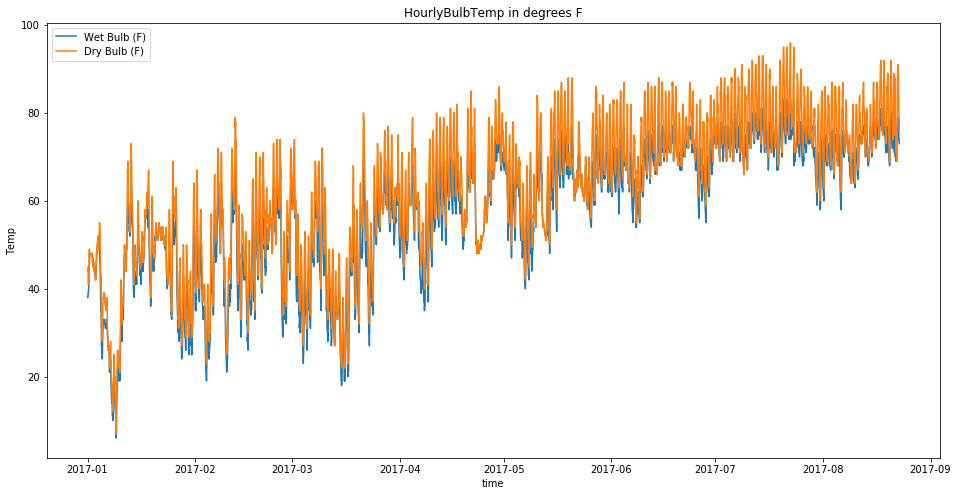

In [25]:
dateTime = gsoDataHourly.index.values
tempWetBulbInF = gsoDataHourly.loc[:,'HOURLYWETBULBTEMPF'].values
tempDryBulbInF = pd.to_numeric(gsoDataHourly.loc[:,'HOURLYDRYBULBTEMPF'].values,errors='coerce')



temp_chart = plt.figure(figsize=(16,8))
temp1 = plt.plot(dateTime, tempWetBulbInF, label= 'Wet Bulb (F)')
temp2 = plt.plot(dateTime, tempDryBulbInF, label= 'Dry Bulb (F)')

plt.title('HourlyBulbTemp in degrees F')

plt.ylabel('Temp')
plt.xlabel('time')
plt.legend(loc=0);